In [1]:
'''
This code is a framework to get biometric data, process data, create & train models.
Inspired from work of https://www.kaggle.com/coni57/model-from-arxiv-1805-00794
'''

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in
import math
import random
import pickle
import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error
from sklearn.utils import shuffle
from scipy.signal import resample
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import os

# to make model making reproducible for comparisons
np.random.seed(42)

Using TensorFlow backend.


In [26]:
#Data addresses and folders
Fitbit_m_dir = "Data/Raw/Heart/Heart_Rate_Data/Fitbit_m/"
Fitbit_h_dir = "Data/Raw/Heart/Heart_Rate_Data/Fitbit_h/"

Selected_fitbit_dir = Fitbit_m_dir

In [27]:
# region scanning the data folders to collect file addresses for input and output
input_files_list = []
output_files_list = []
for root, dirs, files in os.walk(Selected_fitbit_dir):
    for file in files:
        if file.endswith("_x.csv"):
            input_files_list += [file]
        elif file.endswith("_y.csv"):
            output_files_list += [file]
if len(input_files_list) != len(output_files_list):
    raise("we have ODD number of files in the folder. It should be EVEN to have both inputs and outputs.")
print(input_files_list)
print(output_files_list)
# endregion scanning the data folders to collect file addresses for input and output

['20181217_x.csv', '20181218_x.csv', '20181219_x.csv', '20181220_x.csv', '20181221_x.csv', '20181222_x.csv', '20181223_x.csv', '20181224_x.csv', '20181226_x.csv']
['20181217_y.csv', '20181218_y.csv', '20181219_y.csv', '20181220_y.csv', '20181221_y.csv', '20181222_y.csv', '20181223_y.csv', '20181224_y.csv', '20181226_y.csv']


In [29]:
for i in range(len(input_files_list)):
    # region reading data as dataframes.
    input_file_address = os.path.join(Selected_fitbit_dir, input_files_list[2])
    output_file_address = os.path.join(Selected_fitbit_dir, output_files_list[2])
    if (input_file_address[:-6] != output_file_address[:-6]):
        raise("Wrong pair of csv data files selected")

    df_x = pd.read_csv(input_file_address)
    df_y = pd.read_csv(output_file_address)
    # removing the empty rows (rows without Anxiety_Level label) and resetting the index of rows
    df_y = df_y[df_y.Anxiety_Level.isnull() == False].reset_index(drop = True)
    # endregion reading data as dataframes.
    
    # region Parsing Time
    df_x['Time'] = pd.to_datetime(df_x.Time,format= '%H:%M:%S')
    df_y['Time'] = pd.to_datetime(df_y.Time,format= '%H:%M')
    # endregion Parsing Time
    
    

#     for time_y in df_y.Time:
#         df_x_before_time_y = df_x[df_x.Time < time_y]
#         if len(df_x_before_time_y) == 0:
#             continue

In [49]:
# # region example of timedelta by subtracting Timestamp objects
print(df_y.head())
print(type(df_y.Time[0]))
print(type(df_y.Time[3] - df_y.Time[2]))
temp_delta = df_y.Time[3] - df_y.Time[2]
print(temp_delta)
print(temp_delta / 2)
# endregion example code of timedelta by subtracting Timestamp objects

                 Time  Anxiety_Level
0 1900-01-01 09:00:00              1
1 1900-01-01 09:30:00              1
2 1900-01-01 10:00:00              1
3 1900-01-01 10:30:00              2
4 1900-01-01 11:00:00              2
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timedeltas.Timedelta'>
0 days 00:30:00
0 days 00:15:00


In [31]:
def GetSampledData(df_x, time_y, sample_time_range, sampling_period, sampling_method = 'retrospective'):
    if sampling_method == 'retrospective':
        start_time = time_y - sample_time_range
        end_time = time_y
    elif sampling_method == 'uniform':
        start_time = time_y - (sample_time_range / 2)
        end_time = time_y + (sample_time_range / 2)
    elif sampling_method == 'prospective':
        start_time = time_y
        end_time = time_y + sample_time_range
    else:
        raise ("sampling_method not recognized")
    return df_x[(df_x.Time > start_time) & (df_x.Time < end_time)]

In [34]:
#region sampling hyper-parameters
sampling_period = pd.to_timedelta(5, unit='s') #TODO not working yet
print("sampling_period is: " + str(sampling_period))
sample_time_range = pd.to_timedelta(5, unit='m')
print("sample_time_range is: " + str(sample_time_range))
sampling_method = 'retrospective' # can be ['retrospective', 'uniform', 'prospective']
print("sampling method is: " + sampling_method + ". It can be [retrospective, uniform, prospective]")
#endregion sampling hyper-parameters

sampling_period is: 0 days 00:00:05
sample_time_range is: 0 days 00:05:00
sampling method is: retrospective. It can be [retrospective, uniform, prospective]


Anxiety Level = 1


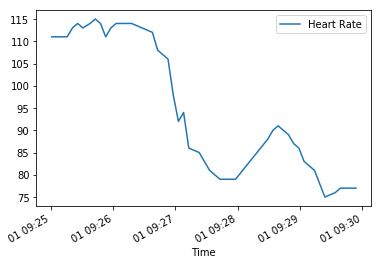

In [36]:
df_y_index = 1

print("Anxiety Level = " + str(df_y.Anxiety_Level[df_y_index]))

df_x_sampled = GetSampledData(df_x, df_y.Time[df_y_index], sample_time_range, sampling_period, sampling_method)
df_x_sampled.plot(x='Time',y='Heart Rate')

In [48]:
import scipy.signal

resampled_df_x, new_t = scipy.signal.resample(list(df_x_sampled['Heart Rate']),20,list(df_x_sampled.Time))

C:\Users\Hooman007\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\Hooman007\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\Hooman007\AppData\Local\Continuum\anaconda3\envs\py35\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depr

TypeError: ufunc add cannot use operands with types dtype('<m8[ns]') and dtype('O')

In [56]:
timestamp=list(df_x_sampled.Time)
timestamp[1]


Timestamp('1900-01-01 09:25:16')

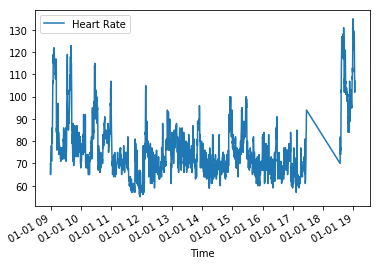

In [9]:
df_x.plot(x='Time', y='Heart Rate')

In [39]:
extracted_df_index = 1 
start_delta_time = df_y.Time[df_y_index] - sampling_period*(extracted_df_index+1)
end_delta_time = df_y.Time[df_y_index] - sampling_period*extracted_df_index

df_x_sampled.loc[(df_x_sampled.Time > start_delta_time) & (df_x_sampled.Time < end_delta_time)]


,Time,Heart Rate
112,1900-01-01 09:29:54,77


In [108]:
df_x_sampled.iloc[[1,2,5,7]]

,Time,Heart Rate
2141,1900-01-01 13:29:09,69
2142,1900-01-01 13:29:14,66
2145,1900-01-01 13:29:34,73
2147,1900-01-01 13:29:44,77
